## 1. Defining the Problem and Assembling a Dataset

**Problem:** Classify movie reviews as positive or negative sentiment.

**Key difference from Twitter example:** This is binary (2 classes) vs. multi-class (3+ classes), affecting output layer and loss function choices.

<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/Final%20DNN%20Code%20Examples/Movie%20Review/Movie%20Review%20-%20NLP%20Binary%20Classification%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Review - NLP Binary Classification Example

This notebook demonstrates the **Universal ML Workflow** for binary sentiment classification on movie reviews.

## Learning Objectives

By the end of this notebook, you will be able to:
- Apply TF-IDF vectorization to text data for binary classification
- Handle nearly-balanced binary classification
- Build and evaluate binary sentiment classifiers
- Compare binary vs. multi-class NLP approaches

---

## Dataset Overview

| Attribute | Description |
|-----------|-------------|
| **Source** | [NLTK Movie Review Dataset](https://www.kaggle.com/datasets/nltkdata/movie-review) |
| **Problem Type** | Binary Classification (Positive/Negative) |
| **Data Balance** | Nearly Balanced (~51% Positive, ~49% Negative) |
| **Data Type** | Unstructured Text (Movie Reviews) |
| **Input Features** | TF-IDF Vectors (5000 features, bigrams) |

---

<a href="https://colab.research.google.com/github/sreent/machine-learning/blob/main/Final%20DNN%20Code%20Examples/Movie%20Review/Movie%20Review%20-%20NLP%20Binary%20Classification%20Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Review - NLP Binary Classification Example

This notebook demonstrates the **Universal ML Workflow** applied to a binary NLP classification problem for sentiment analysis of movie reviews.

## 2. Choosing a Measure of Success

For this nearly-balanced binary classification:
- **Balanced Accuracy** still useful for consistency
- Standard **Accuracy** is also meaningful here
- **Precision, Recall, AUC** for comprehensive evaluation

## 3. Deciding on an Evaluation Protocol

Standard hold-out + validation + K-fold cross-validation approach.

## 4. Preparing Your Data

### 4.1 Import Libraries and Load Dataset

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

# Keras Tuner for hyperparameter search
!pip install -q -U keras-tuner
import keras_tuner as kt

import itertools
import matplotlib.pyplot as plt

SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [2]:
reviews = pd.read_csv('movie_review.csv', sep=',')
reviews = reviews[['text', 'tag']]

reviews.head()

,text,tag
0,films adapted from comic books have had plenty...,pos
1,"for starters , it was created by alan moore ( ...",pos
2,to say moore and campbell thoroughly researche...,pos
3,"the book ( or "" graphic novel , "" if you will ...",pos
4,"in other words , don't dismiss this film becau...",pos


In [3]:
TEST_SIZE = 0.1

(text_train, text_test, 
 tag_train, tag_test) = train_test_split(reviews['text'], reviews['tag'], 
                                         test_size=TEST_SIZE, stratify=reviews['tag'],
                                                     shuffle=True, random_state=SEED)

In [4]:
MAX_FEATURES = 5000
NGRAMS = 2

tfidf = TfidfVectorizer(ngram_range=(1, NGRAMS), max_features=MAX_FEATURES)
tfidf.fit(text_train)

X_train, X_test = tfidf.transform(text_train).toarray(), tfidf.transform(text_test).toarray()

In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(reviews['tag'])

y_train = label_encoder.transform(tag_train)
y_test = label_encoder.transform(tag_test)

In [6]:
VALIDATION_SIZE = X_test.shape[0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                 test_size=VALIDATION_SIZE, stratify=y_train,
                                                 shuffle=True, random_state=SEED)

## 5. Developing a Model That Does Better Than a Baseline

Baseline for nearly-balanced binary: ~51% (majority class)

In [7]:
counts = reviews.groupby(['tag']).count()
counts.reset_index(inplace=True)

counts

,tag,text
0,neg,31783
1,pos,32937


In [8]:
# the class is off-balanced, but very minimal 

baseline = counts[counts['tag']=='pos']['text'].values[0] / counts['text'].sum()

baseline

0.5089153275648949

In [9]:
balanced_accuracy_baseline = balanced_accuracy_score(y_train, np.zeros(len(y_train)))

In [10]:
# MLP Model Instatiation
def deep_neural_network(hidden_layers=0, hidden_neurons=np.nan, activation=None,
                        dropout=np.nan, input_dimension=2, output_dimension=1,
                        optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'],
                        name=None) :
    
    model = Sequential()
    for layer in range(hidden_layers) :
        model.add(Dense(hidden_neurons, 
                  activation=activation, 
                  input_shape='default' if layer>1 else (input_dimension,)))
        if ~np.isnan(dropout) :
            model.add(Dropout(dropout))
        
    model.add(Dense(output_dimension, 
                    activation='sigmoid' if output_dimension==1 else 'softmax',
                    input_shape='default' if hidden_layers>0 else (input_dimension,)))
  
    if name is not None :
        model._name = name
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

In [11]:
# Fitting MLP Classification Model
def train_deep_neural_network(model, X, y, 
                              class_weights,
                              batch_size=32, epochs=100, 
                              val_data=None, callbacks=[], seed=0) :
    
    if val_data is None :
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                          random_state=seed, shuffle=True, 
                                                          stratify=y)
        
    else :
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]
  

    history = model.fit(X_train, y_train,
                        class_weight=class_weights,
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(X_val, y_val),
                        callbacks=callbacks,
                        verbose=0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:], 
            'history': history }

In [12]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc', multi_label=True)]

2023-02-26 13:00:32.082616: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-26 13:00:32.082637: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-26 13:00:32.082653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (snottingham): /proc/driver/nvidia/version does not exist
2023-02-26 13:00:32.082850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
learning_rate = 0.001

slp_model = deep_neural_network(hidden_layers=0, 
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=RMSprop(learning_rate=learning_rate), 
                                loss=LOSS_FUNC, metrics=METRICS,
                                name='Single_Layer_Perceptron')

slp_model.summary()

Model: "Single_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 5001      
                                                                 
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 512
EPOCHS = 100

In [15]:
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
CLASS_WEIGHTS = dict(enumerate(weights))

CLASS_WEIGHTS

{0: 1.0181303338970387, 1: 0.9825040798512278}

In [ ]:
trained_slp_model = train_deep_neural_network(slp_model, X_train, y_train,
                                              CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=500, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[], seed=SEED)

In [17]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_slp_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_slp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_slp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_slp_model['val_score'][3]))

Accuracy (Validation): 0.65 (baseline=0.51)
Precision (Validation): 0.66
Recall (Validation): 0.66
AUC (Validation): 0.72


In [18]:
preds = trained_slp_model['model'].predict(X_val, verbose=0)

print('Balanced Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(balanced_accuracy_score(y_val, (preds > 0.5).astype('int32')), balanced_accuracy_baseline))

Balanced Accuracy (Validation): 0.65 (baseline=0.50)


In [19]:
def plot_training_history(history, monitors=['loss', 'AUC']) :

  # using the variable axs for multiple Axes
  fig, axs = plt.subplots(1, 2, sharex='all', figsize=(15,5))
 
  for ax, monitor in zip(axs.flat, monitors) :
    loss, val_loss = history.history[monitor], history.history['val_' + monitor]

    if monitor == 'loss' :
      monitor = monitor.capitalize()

    epochs = range(1, len(loss)+1)

    ax.plot(epochs, loss, 'b.', label=monitor)
    ax.plot(epochs, val_loss, 'r.', label='Validation ' + monitor)
    ax.set_xlim([0, len(loss)])
    ax.title.set_text('Training and Validation ' + monitor + 's')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(monitor)
    ax.legend()
    ax.grid()

  _ = plt.show()

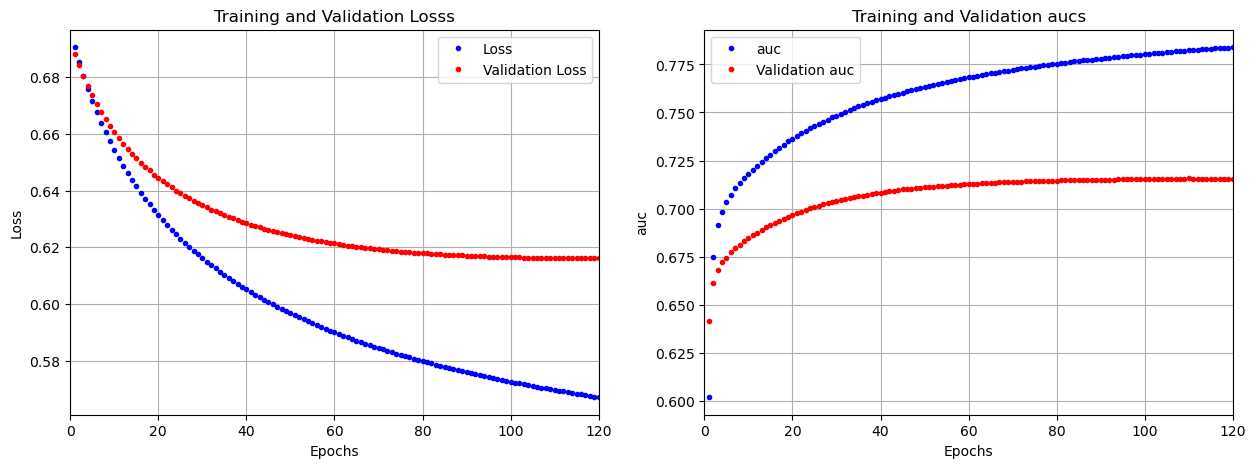

In [20]:
plot_training_history(trained_slp_model['history'], monitors=['loss', 'auc'])

## 6. Scaling Up: Developing a Model That Overfits

Adding hidden layers for increased capacity.

In [21]:
learning_rate = 0.0002

mlp_model = deep_neural_network(hidden_layers=1, hidden_neurons=64,
                                activation='relu',
                                input_dimension=INPUT_DIMENSION, output_dimension=OUTPUT_DIMENSION,
                                optimizer=RMSprop(learning_rate=learning_rate), 
                                loss=LOSS_FUNC, metrics=METRICS,
                                name='Multi_Layer_Perceptron')

mlp_model.summary()

Model: "Multi_Layer_Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                320064    
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 320,129
Trainable params: 320,129
Non-trainable params: 0
_________________________________________________________________


In [22]:
trained_mlp_model = train_deep_neural_network(mlp_model, X_train, y_train,
                                              CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[], seed=SEED)

2023-02-26 13:01:58.508851: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1035520000 exceeds 10% of free system memory.


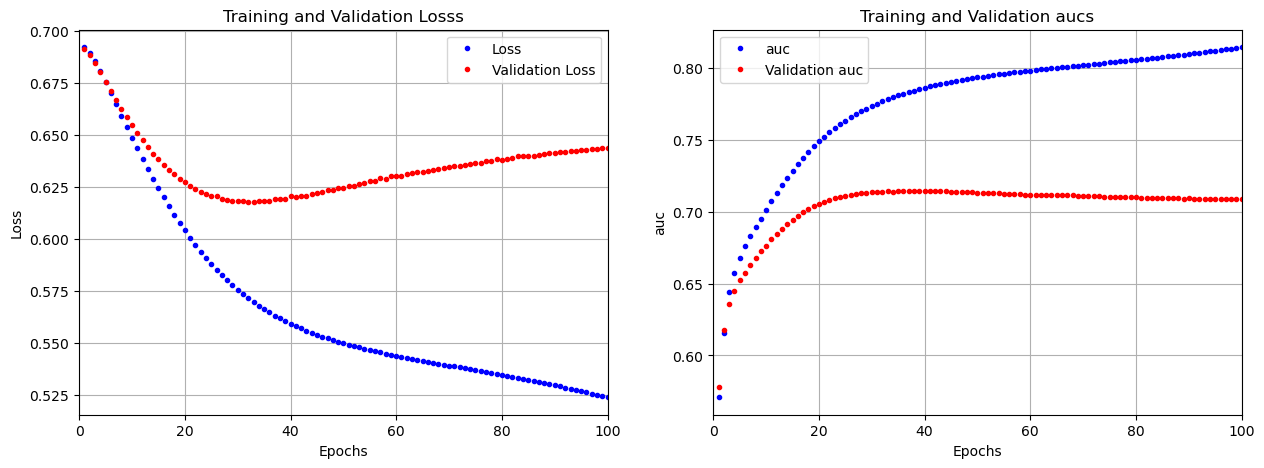

In [23]:
plot_training_history(trained_mlp_model['history'], monitors=['loss', 'auc'])

In [24]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_mlp_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_mlp_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_mlp_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_mlp_model['val_score'][3]))

Accuracy (Validation): 0.65 (baseline=0.51)
Precision (Validation): 0.65
Recall (Validation): 0.65
AUC (Validation): 0.71


In [25]:
preds = trained_mlp_model['model'].predict(X_val, verbose=0)

print('Balanced Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(balanced_accuracy_score(y_val, (preds > 0.5).astype('int32')), balanced_accuracy_baseline))

Balanced Accuracy (Validation): 0.64 (baseline=0.50)


## 7. Regularizing Your Model and Tuning Hyperparameters

Using **Hyperband** for efficient hyperparameter tuning with a frozen architecture.

### Why Hyperband?

**Hyperband** is more efficient than grid search because it:
1. Starts training many configurations for a few epochs
2. Eliminates poor performers early
3. Allocates more resources to promising configurations

In [ ]:
# Hyperband Model Builder for Binary NLP Classification
def build_model_hyperband(hp):
    """
    Build Movie Review model with FROZEN architecture (2 layers: 64 -> 32 neurons).
    Only tunes regularization (Dropout) and learning rate.
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(INPUT_DIMENSION,)))

    # Fixed architecture: 2 hidden layers with 64 and 32 neurons
    # Layer 1: 64 neurons
    model.add(layers.Dense(64, activation='relu'))
    drop_0 = hp.Float('drop_0', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_0))

    # Layer 2: 32 neurons
    model.add(layers.Dense(32, activation='relu'))
    drop_1 = hp.Float('drop_1', 0.0, 0.5, step=0.1)
    model.add(layers.Dropout(drop_1))

    # Output layer for binary classification
    model.add(layers.Dense(OUTPUT_DIMENSION, activation='sigmoid'))

    lr = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=LOSS_FUNC,
        metrics=METRICS
    )
    return model

In [ ]:
# Configure Hyperband tuner
tuner = kt.Hyperband(
    build_model_hyperband,
    objective='val_auc',
    max_epochs=20,
    factor=3,
    directory='movie_review_hyperband',
    project_name='movie_review_tuning'
)

# Run Hyperband search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=batch_size,
    class_weight=CLASS_WEIGHTS
)

In [29]:
KFOLDS = 5

In [31]:
stats.sort_values(by=['auc'], ascending=False).head(10)

,hidden_layers,neurons,activation,dropout,batch_size,epochs,val_loss,categorical_accuracy,precision,recall,auc,balanced_accuracy
0,1,64,relu,0.2,512,45.0,0.622094,0.651731,0.657062,0.660442,0.710086,0.651573
1,2,64,relu,0.2,512,21.4,0.623049,0.650688,0.657583,0.655054,0.709954,0.650609


In [35]:
trained_opt_model = train_deep_neural_network(opt_model, X_train, y_train,
                                              CLASS_WEIGHTS,
                                              batch_size=batch_size, epochs=EPOCHS, 
                                              val_data=(X_val, y_val), 
                                              callbacks=[EARLY_STOP], seed=SEED)

In [40]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(trained_opt_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(trained_opt_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(trained_opt_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(trained_opt_model['val_score'][3]))

Accuracy (Validation): 0.65 (baseline=0.51)
Precision (Validation): 0.66
Recall (Validation): 0.66
AUC (Validation): 0.71


In [ ]:
# Get best hyperparameters and build best model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"  Dropout Layer 1: {best_hp.get('drop_0')}")
print(f"  Dropout Layer 2: {best_hp.get('drop_1')}")
print(f"  Learning Rate: {best_hp.get('lr')}")

opt_model = tuner.hypermodel.build(best_hp)
opt_model.summary()

In [ ]:
# Train the best model
history_opt = opt_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=batch_size,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

trained_opt_model = {
    'model': opt_model,
    'val_score': opt_model.evaluate(X_val, y_val, verbose=0)[1:],
    'history': history_opt
}

In [46]:
print('Balanced Accuracy (Validation): {:.2f} (baseline = 0.33)'.format(balanced_accuracy_score(y_test, (preds > 0.5).astype('int32'))))

Balanced Accuracy (Validation): 0.65 (baseline = 0.33)


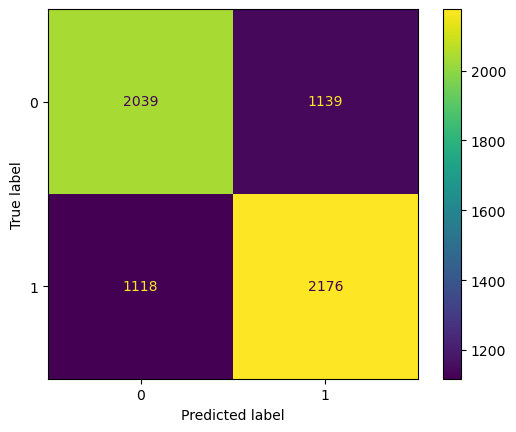

In [48]:
disp = ConfusionMatrixDisplay( confusion_matrix(y_test, (preds > 0.5).astype('int32')) )
_ = disp.plot()

---

## 8. Key Takeaways

1. **Binary Classification Specifics:**
   - Output layer: 1 neuron with sigmoid activation
   - Loss: Binary cross-entropy
   - Predictions: Threshold at 0.5

2. **Class weights optional** when classes are nearly balanced (~51:49)

3. **Same TF-IDF pipeline** works for binary and multi-class NLP